In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-11-02 15:13:47.711041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib is building the font cache; this may take a moment.


In [2]:
#Load dataset from csv file
dataset = np.loadtxt('dataset.csv', delimiter=',')
print(dataset.shape)

(112, 32)


### 1. The EM Algorithm
EM Algorithm Overview:

E-step: Compute the expected value of the log-likelihood function, given the current estimate of the parameters.

M-step: Update the model parameters by maximizing the expected log-likelihood obtained in the E-step.

### 2. Markov Chain Monte Carlo (MCMC)
MCMC Overview:

Purpose: Approximate complex probability distributions by constructing a Markov chain.

Method: Generate samples from a proposal distribution and accept/reject them based on an acceptance criterion.

### 3. MCMC-EM in Autoencoders
MCMC-EM Overview:

Integration: Use MCMC sampling within the EM algorithm to perform Bayesian inference and find the posterior distribution over model parameters.

Steps:
- Prior Distribution: Define a prior over the model parameters.
- Likelihood Function: Define the likelihood of data given latent variables and model parameters.
- Posterior Distribution: Define the posterior distribution of latent variables given data and model parameters.

Steps of MCMC-EM in Autoencoders:

- Initialization: Initialize model parameters and latent variables.
- E-step: Sample latent variables from the posterior distribution using MCMC.
- M-step: Update model parameters using the expected values from the E-step.
- Repeat: Continue until convergence.

### Steps in mcmc_em:

- Initialization: Parameters are initialized when the autoencoder is created, and latent variables are initialized in the E-step.

- E-step: Uses mcmc_sampling to sample latent variables from the posterior.

- M-step: Updates model parameters by minimizing the reconstruction loss (binary cross-entropy) using the sampled latent variables.

### Summary
The provided implementation:

- Initializes model parameters and latent variables.
- Uses MCMC sampling to generate latent variable samples (E-step).
- Updates the model parameters by minimizing the reconstruction loss using the sampled latent variables (M-step).
- Repeats the E-step and M-step until convergence.
- This aligns with the EM algorithm and MCMC principles described in your text, integrating them into an autoencoder framework to perform Bayesian inference and parameter estimation.

In [4]:


def plot_loss(losses):
    """
    Plots the loss over epochs.

    Parameters:
    losses (list of float): List of loss values recorded at each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Define the encoder
class Encoder(Model):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = layers.Dense(hidden_dim, activation='relu')
        self.fc2 = layers.Dense(latent_dim)

    def call(self, x):
        h = self.fc1(x)
        return self.fc2(h)

# Define the decoder
class Decoder(Model):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = layers.Dense(hidden_dim, activation='relu')
        self.fc2 = layers.Dense(output_dim, activation='sigmoid')

    def call(self, z):
        h = self.fc1(z)
        return self.fc2(h)

# Define the autoencoder model
class Autoencoder(Model):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def call(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

# Function to run MCMC (simplified)
def mcmc_sampling(z_init, decoder, num_samples=1000):
    z_current = z_init
    samples = [z_current]
    for _ in range(num_samples):
        z_proposal = z_current + tf.random.normal(tf.shape(z_current), mean=0.0, stddev=0.1)  # Random walk proposal
        p_current = tf.reduce_mean(decoder(z_current))
        p_proposal = tf.reduce_mean(decoder(z_proposal))
        acceptance_ratio = tf.exp(p_proposal - p_current)
        if tf.random.uniform([]) < acceptance_ratio:
            z_current = z_proposal
        samples.append(z_current)
    return tf.stack(samples)

# Define the MCMC-EM procedure
def mcmc_em(autoencoder, data, num_epochs=10, mcmc_samples=100):
    optimizer = Adam(learning_rate=1e-3)
    losses = []
    for epoch in range(num_epochs):
        for x in data:
            x = tf.reshape(x, [-1, input_dim])
            
            with tf.GradientTape() as tape:
                # E-Step: MCMC sampling
                _, z_init = autoencoder(x)
                z_samples = mcmc_sampling(z_init, autoencoder.decoder, num_samples=mcmc_samples)
                
                # M-Step: Parameter update
                recon_x = autoencoder.decoder(tf.reduce_mean(z_samples, axis=0))  # Use mean of samples
                loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x))
            
            gradients = tape.gradient(loss, autoencoder.trainable_variables)
            optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
            
        losses.append(loss.numpy())  # Record the loss for this epoch
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')
    plot_loss(losses)

# Dummy data loader (replace with actual data loader)
# Assuming `train_loader` provides batches of data (x)
(input_dim, hidden_dim, latent_dim) = (32, 16, 4)
autoencoder = Autoencoder(input_dim, hidden_dim, latent_dim)

# # Create a dummy dataset (replace with actual dataset)
# (train_data, _), _ = tf.keras.datasets.mnist.load_data()
# train_data = train_data / 255.0
# train_data = train_data.reshape(-1, 784)
train_data = dataset
train_loader = tf.data.Dataset.from_tensor_slices(train_data).batch(128)




In [5]:
print(train_loader)

<_BatchDataset element_spec=TensorSpec(shape=(None, 32), dtype=tf.float64, name=None)>


2024-11-02 15:14:23.465543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: 79.3606948852539


2024-11-02 15:14:24.062869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 79.11357879638672


2024-11-02 15:14:24.605200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 79.03325653076172


2024-11-02 15:14:25.312333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 78.58389282226562


2024-11-02 15:14:25.794741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 78.71292114257812


2024-11-02 15:14:26.306561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Loss: 78.80874633789062


2024-11-02 15:14:26.810979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Loss: 78.437744140625


2024-11-02 15:14:27.290487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Loss: 78.21369934082031


2024-11-02 15:14:27.844098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 78.23460388183594


2024-11-02 15:14:28.359563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Loss: 78.13128662109375


2024-11-02 15:14:28.836296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10, Loss: 77.9149169921875


2024-11-02 15:14:29.320392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11, Loss: 77.92263793945312


2024-11-02 15:14:29.801445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12, Loss: 77.79553985595703


2024-11-02 15:14:30.275737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13, Loss: 77.84358215332031


2024-11-02 15:14:30.749298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14, Loss: 77.66065216064453


2024-11-02 15:14:31.227681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15, Loss: 77.6866683959961


2024-11-02 15:14:31.784338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Loss: 77.51280975341797


2024-11-02 15:14:32.400525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17, Loss: 77.25242614746094


2024-11-02 15:14:32.898542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18, Loss: 77.46509552001953


2024-11-02 15:14:33.527143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19, Loss: 77.21298217773438


2024-11-02 15:14:34.042498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20, Loss: 77.22463989257812


2024-11-02 15:14:34.527545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21, Loss: 77.09580993652344


2024-11-02 15:14:35.047772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22, Loss: 77.16190338134766


2024-11-02 15:14:35.527700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23, Loss: 77.04894256591797


2024-11-02 15:14:36.158521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24, Loss: 77.02959442138672


2024-11-02 15:14:36.676462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25, Loss: 77.04337310791016


2024-11-02 15:14:37.292511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26, Loss: 76.859130859375


2024-11-02 15:14:37.730035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27, Loss: 76.69964599609375


2024-11-02 15:14:38.310737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28, Loss: 76.78044128417969


2024-11-02 15:14:38.871935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29, Loss: 76.45435333251953


2024-11-02 15:14:39.434585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30, Loss: 76.36907196044922


2024-11-02 15:14:39.954635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31, Loss: 76.61233520507812


2024-11-02 15:14:40.454600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32, Loss: 76.44652557373047


2024-11-02 15:14:41.109442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33, Loss: 76.42657470703125


2024-11-02 15:14:41.802572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34, Loss: 76.24019622802734


2024-11-02 15:14:42.480240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35, Loss: 76.20476531982422


2024-11-02 15:14:43.063386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36, Loss: 76.3148193359375


2024-11-02 15:14:43.591092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37, Loss: 76.03617095947266


2024-11-02 15:14:44.099328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38, Loss: 76.21736907958984


2024-11-02 15:14:44.696487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39, Loss: 75.95166015625


2024-11-02 15:14:45.325667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40, Loss: 75.68743896484375


2024-11-02 15:14:45.919866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41, Loss: 75.5962142944336


2024-11-02 15:14:46.439955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42, Loss: 75.70231628417969


2024-11-02 15:14:46.931392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43, Loss: 75.37411499023438


2024-11-02 15:14:47.411237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44, Loss: 75.52224731445312


2024-11-02 15:14:47.984066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45, Loss: 75.52293395996094


2024-11-02 15:14:48.496304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46, Loss: 75.30244445800781


2024-11-02 15:14:49.105970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47, Loss: 75.1897964477539


2024-11-02 15:14:49.652001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48, Loss: 75.51582336425781


2024-11-02 15:14:50.133975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49, Loss: 75.27853393554688


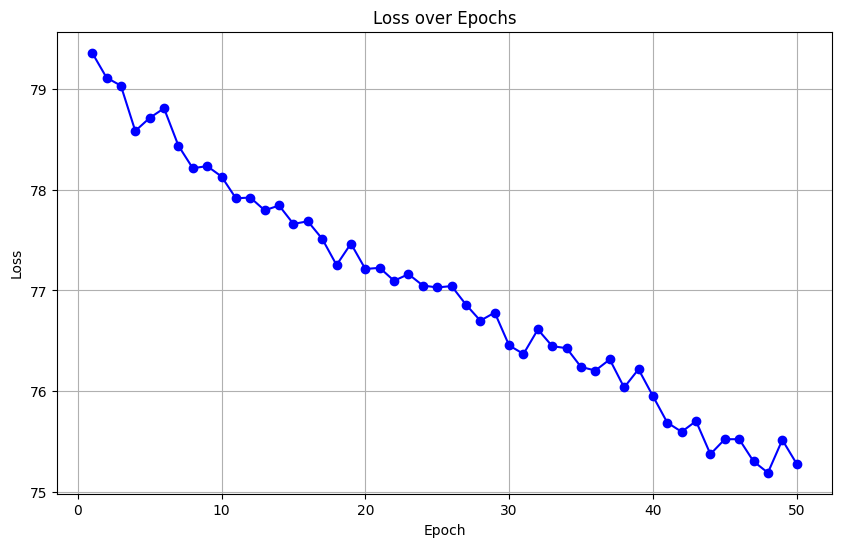

In [6]:
# Run the MCMC-EM procedure
mcmc_em(autoencoder, train_loader,num_epochs=50)

In [7]:

#Sending training data through TRAINED encoder to get vectors to visualise latent space
latent_vectors = []
for testing in dataset:
    test_data = testing

    test_data = np.reshape(test_data, (1, 32))

    encoded_data = autoencoder.encoder(test_data)

    latent_vectors.append(encoded_data[0])


latent_vectors = np.array(latent_vectors)



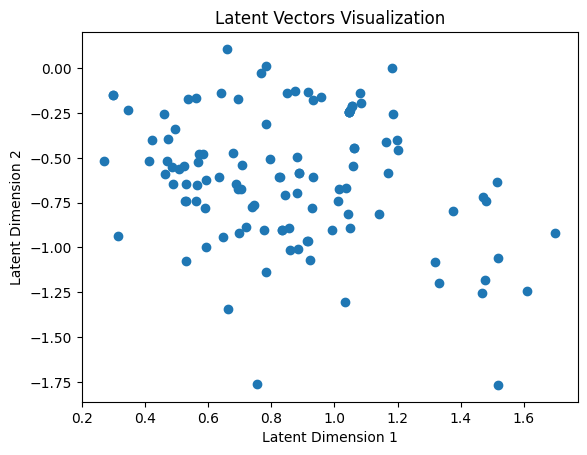

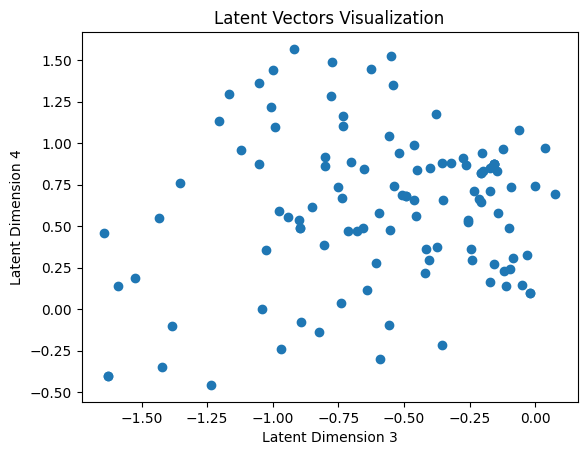

In [8]:
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Vectors Visualization')
plt.show()

plt.scatter(latent_vectors[:, 2], latent_vectors[:, 3])
plt.xlabel('Latent Dimension 3')
plt.ylabel('Latent Dimension 4')
plt.title('Latent Vectors Visualization')
plt.show()

In [9]:
# Function to generate new data using the decoder
def generate_new_data(decoder, latent_dim, num_samples):
    z_samples = tf.random.normal(shape=(num_samples, latent_dim))  # Sample from the prior distribution
    generated_data = decoder(z_samples)
#     print(z_samples)
    return generated_data.numpy()

In [14]:
gen_vec = tf.constant([[-1.0000149, -0.1869866, -0.6511309,  0.5902724]])
print(gen_vec)
op = autoencoder.decoder(gen_vec)
print(op)

tf.Tensor([[-1.0000149 -0.1869866 -0.6511309  0.5902724]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[0.5669158  0.4230118  0.6269203  0.51856595 0.648252   0.5694239
  0.52465516 0.43516558 0.41501188 0.56592214 0.538306   0.65385026
  0.370468   0.5849295  0.6694172  0.5520542  0.56710154 0.4965305
  0.36754414 0.33688402 0.36051625 0.4855571  0.3817715  0.39267305
  0.2678915  0.3810772  0.49137717 0.39408106 0.4473078  0.6313852
  0.3322208  0.5475397 ]], shape=(1, 32), dtype=float32)


In [22]:
# Generate new data samples
num_samples_to_generate = 1
generated_rhythm = generate_new_data(autoencoder.decoder, latent_dim, num_samples_to_generate)

# generated_data = autoencoder.decoder(z_samples)

# Print the generated data
# print("Generated Data Samples:\n", generated_rhythm)

split = np.split(generated_rhythm[0],2)

steps = split[0]

substeps = split[1]

output1 = []
output2 = []
seq=[]
tolerance=0.5
for op in steps:
    if op > tolerance:
        output1.append(1)
    else: output1.append(0)
        
for s in substeps:
    op = int(s * (6 - -6) + -6)
    output2.append(op)
    
# print('AE: Raw Generation ',generated_rhythm)
print('Step on/off: ',output1)
print('48-PPQN substeps ',output2)

Step on/off:  [0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
48-PPQN substeps  [0, 0, -1, -1, -1, -1, -1, -1, -3, -1, 1, 0, -1, 1, -1, 1]


### Technique

**MCMC-EM Autoencoders:**

- **E-step:** Involves MCMC sampling to draw samples from the posterior distribution of the latent variables given the observed data.
- **M-step:** Updates the model parameters by maximizing the expected log-likelihood obtained from the E-step.
- **Posterior Sampling:** Uses MCMC methods like Metropolis-Hastings to sample from the posterior distribution, which can be computationally intensive.
- **Likelihood Calculation:** Uses exact or approximate likelihood calculations, often involving multiple samples to estimate the expectation.

**Variational Autoencoders (VAEs):**

- **Encoder (Inference Model):** Uses a neural network to parameterize a variational distribution (usually Gaussian) over the latent variables given the observed data.
- **Decoder (Generative Model):** Another neural network reconstructs the data from the sampled latent variables.
- **Evidence Lower Bound (ELBO):** Maximizes a lower bound on the log-likelihood of the data, decomposing it into a reconstruction term and a KL-divergence term between the variational distribution and the prior.
- **Reparameterization Trick:** Allows backpropagation through the sampling step by reparameterizing the latent variables as a deterministic function of the variational parameters and a random noise.

### Level of Stochasticity

**MCMC-EM Autoencoders:**

- **Stochasticity in E-step:** Introduced through MCMC sampling, where each sample of the latent variables involves a stochastic proposal and acceptance/rejection step.
- **Deterministic M-step:** The parameter updates in the M-step are typically deterministic given the samples from the E-step.
- **Overall Stochasticity:** Higher due to the nature of MCMC sampling, which involves generating a sequence of samples to approximate the posterior distribution.

**Variational Autoencoders (VAEs):**

- **Stochastic Encoder:** The encoder outputs parameters of a variational distribution (e.g., mean and variance of a Gaussian), and latent variables are sampled from this distribution.
- **Reparameterization Trick:** Introduces controlled stochasticity by expressing the latent variables as a function of the encoder output and random noise.
- **Overall Stochasticity:** Controlled and more efficient due to the direct sampling from a parameterized distribution and the reparameterization trick.

### Computational Load

**MCMC-EM Autoencoders:**

- **E-step Computational Load:** High, as it involves running MCMC chains for each data point to obtain posterior samples. This can be computationally expensive, especially with complex models or large datasets.
- **M-step Computational Load:** Moderate, involves standard gradient-based optimization but can be repeated multiple times depending on the convergence of the MCMC step.
- **Convergence:** Can be slow due to the iterative nature of MCMC, requiring many samples to approximate the posterior accurately.

**Variational Autoencoders (VAEs):**

- **Encoder and Decoder Computations:** Standard forward passes through neural networks, which are computationally efficient and parallelizable on modern hardware like GPUs.
- **KL-divergence Calculation:** Computationally efficient, typically involves simple operations with the output of the encoder.
- **Optimization:** Directly optimizes the ELBO using standard gradient-based methods, making it faster and more scalable for large datasets.
- **Convergence:** Typically faster due to the direct optimization of the variational objective and the use of efficient stochastic gradient descent methods.

### Summary of Comparison

| Aspect                 | MCMC-EM Autoencoders                        | Variational Autoencoders (VAEs)            |
|------------------------|---------------------------------------------|-------------------------------------------|
| **Technique**          | MCMC sampling, iterative EM steps           | Variational inference, direct ELBO maximization |
| **Stochasticity**      | High (due to MCMC sampling)                 | Controlled (due to reparameterization trick) |
| **Computational Load** | High (due to MCMC chains in E-step)         | Lower (efficient neural network computations) |
| **Convergence Speed**  | Slower (requires many MCMC samples)         | Faster (direct optimization of ELBO)      |

### Conclusion

- **MCMC-EM Autoencoders:** Offer a more rigorous Bayesian approach by explicitly sampling from the posterior distribution, capturing complex dependencies in the latent space. However, this comes at the cost of higher computational load and slower convergence.
- **Variational Autoencoders (VAEs):** Provide a more computationally efficient and scalable approach to approximate Bayesian inference. The use of the reparameterization trick and direct optimization of the ELBO make VAEs suitable for large-scale and complex datasets, although they may sometimes provide less accurate posterior approximations compared to MCMC methods.

Choosing between these methods depends on the specific requirements of the task, including the desired accuracy of the posterior approximation, available computational resources, and the complexity of the dataset.